In [ ]:
!python -V

Python 3.11.12


In [ ]:
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install imbalanced-learn
!pip install matplotlib
!pip install joblib
!pip install shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import shap
import gc

In [3]:
def loader(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip()
    df = df[df['Flow ID'] != 'Flow ID']
    return df

# Primo blocco
df1 = loader('/content/drive/MyDrive/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = loader('/content/drive/MyDrive/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
part1 = pd.concat([df1, df2], ignore_index=True)
del df1, df2
gc.collect()

# Secondo blocco
df3 = loader('/content/drive/MyDrive/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = loader('/content/drive/MyDrive/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv')
part2 = pd.concat([df3, df4], ignore_index=True)
del df3, df4
gc.collect()

# Terzo blocco
df5 = loader('/content/drive/MyDrive/TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('/content/drive/MyDrive/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', low_memory=False, encoding='latin-1')
df6.columns = df6.columns.str.strip()
df6 = df6[df6['Flow ID'] != 'Flow ID']
part3 = pd.concat([df5, df6], ignore_index=True)
del df5, df6
gc.collect()

# Quarto blocco
df7 = loader('/content/drive/MyDrive/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = loader('/content/drive/MyDrive/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv')
part4 = pd.concat([df7, df8], ignore_index=True)
del df7, df8
gc.collect()

# Concatenazione finale
df = pd.concat([part1, part2, part3, part4], ignore_index=True)
del part1, part2, part3, part4
gc.collect()

# Conversione Label in valori numerici
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')


Distribuzione etichette dopo mapping:
Attack Type
BENIGN          2273097
Unknown          288602
DoS              252661
PortScan         158930
DDoS             128027
Brute Force       13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


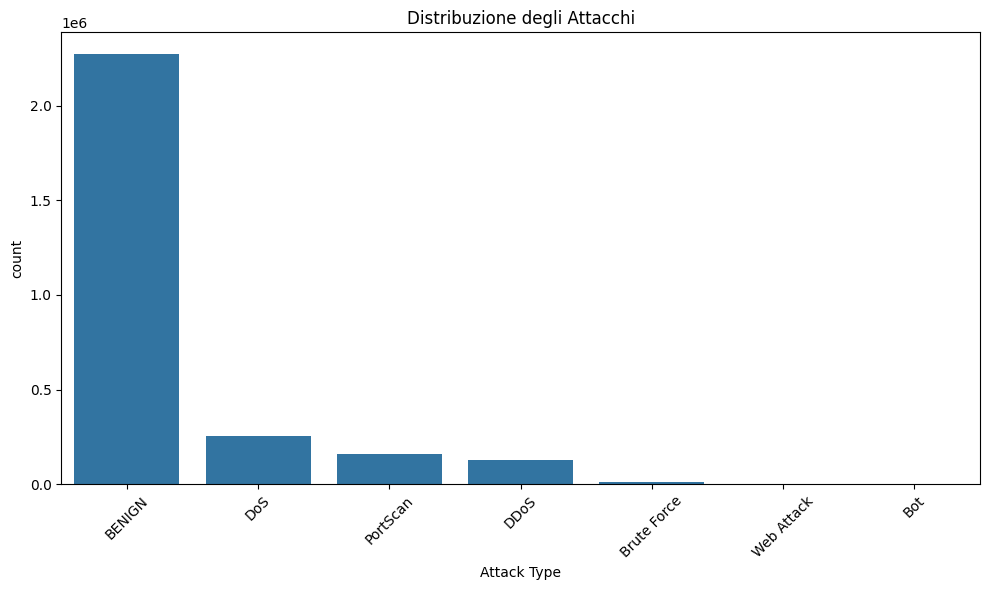

Distribuzione originale: Counter({0: 2273097, 4: 252661, 5: 158930, 3: 128027, 2: 13835, 6: 2180, 1: 1966})
Distribuzione dopo bilanciamento: Counter({0: 1966, 1: 1966, 2: 1966, 3: 1966, 4: 1966, 5: 1966, 6: 1966})


In [4]:

# Mappatura dei tipi di attacco
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'PortScan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Normalizzazione e pulizia etichette
df['Label'] = df['Label'].astype(str).str.strip()
df['Label'] = df['Label'].str.replace('–', '-', regex=False)
df['Label'] = df['Label'].str.replace(' +', ' ', regex=True)

# Mappatura
df['Attack Type'] = df['Label'].map(lambda x: attack_map.get(x, 'Unknown'))
print("Distribuzione etichette dopo mapping:")
print(df['Attack Type'].value_counts())

# Rimuove classi rare
rare_classes = ['Heartbleed', 'Infiltration']
df = df[~df['Attack Type'].isin(rare_classes)]

# Filtra solo etichette valide
df = df[df['Attack Type'] != 'Unknown']


# Distribuzione delle classi (countplot)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Attack Type', order=df['Attack Type'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribuzione degli Attacchi")
plt.tight_layout()
plt.show()

# Codifica le classi
le = LabelEncoder()
df['Attack Number'] = le.fit_transform(df['Attack Type'])

# Prepara X e y
X = df.drop(['Label', 'Attack Type', 'Attack Number'], axis=1, errors='ignore')
y = df['Attack Number']

# Bilanciamento con RandomUnderSampler
print("Distribuzione originale:", Counter(y))
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("Distribuzione dopo bilanciamento:", Counter(y_resampled))


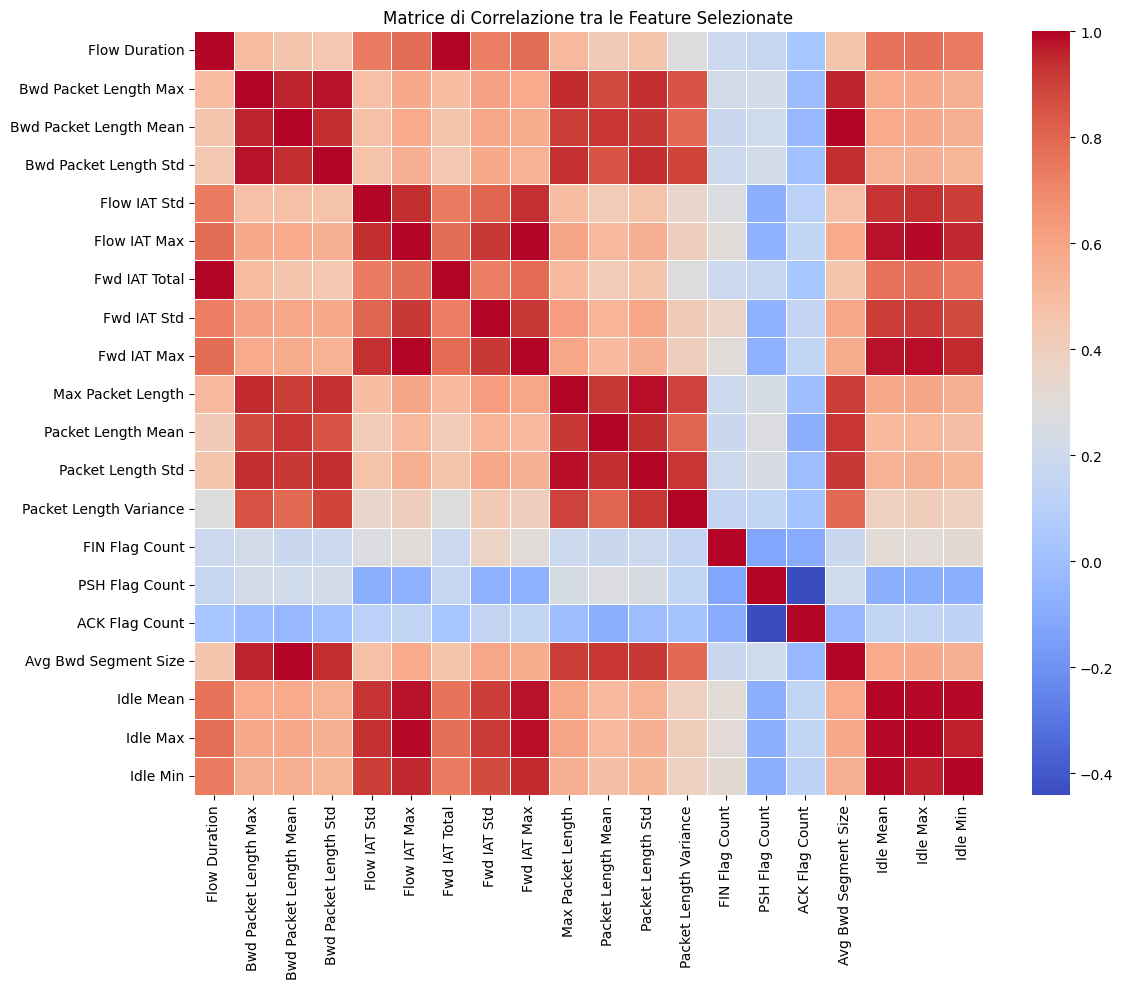

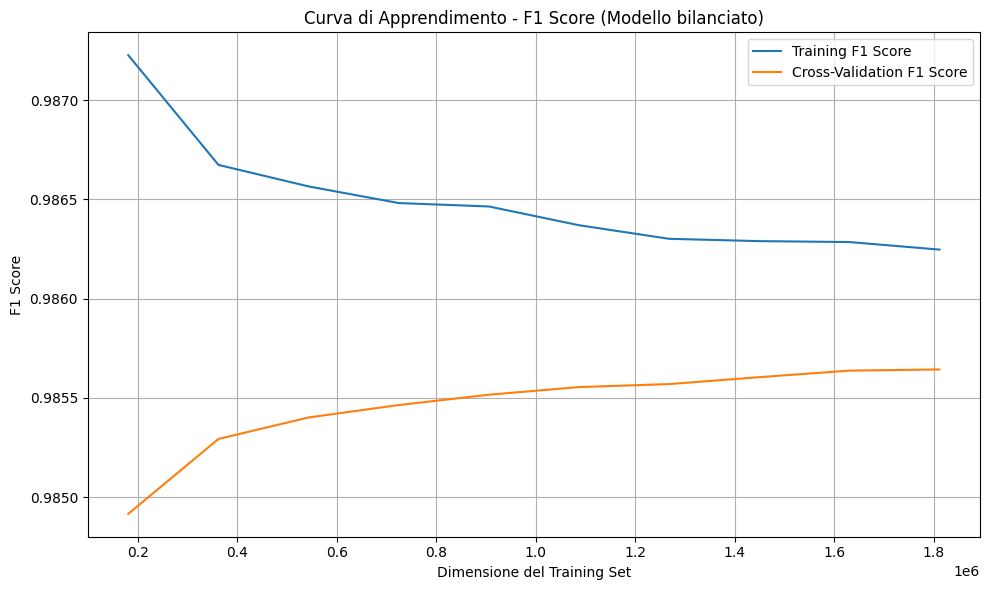

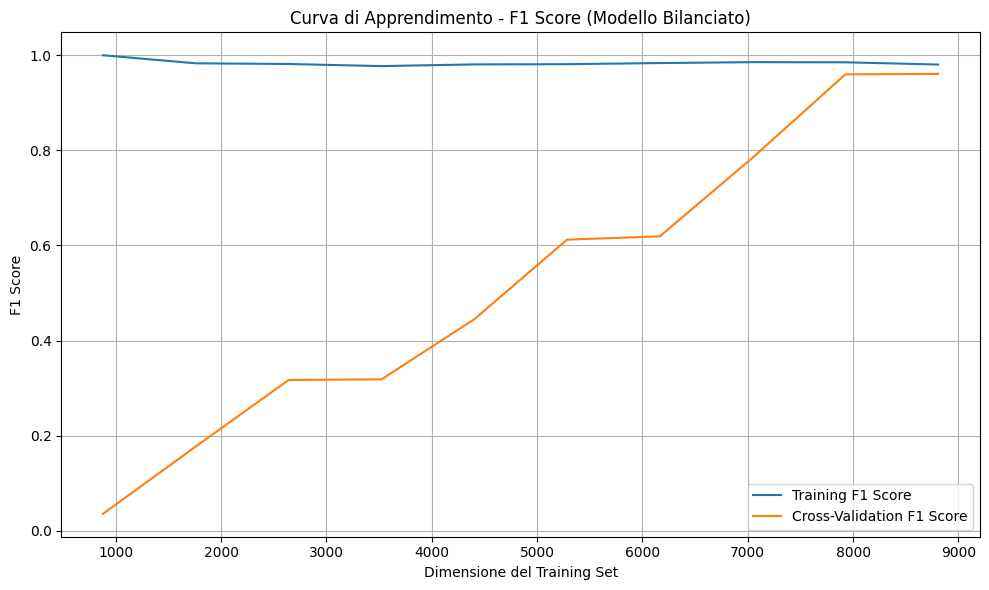


--- Test Set (Sbilanciato) ---
Accuracy: 0.9859646023951673
F1 Score: 0.9858148822759902
Precision: 0.9865337275516963
Recall: 0.9859646023951673
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    454620
           1       0.90      0.42      0.58       393
           2       1.00      0.79      0.88      2767
           3       1.00      1.00      1.00     25606
           4       0.91      0.97      0.94     50532
           5       0.99      1.00      1.00     31786
           6       0.99      0.21      0.35       436

    accuracy                           0.99    566140
   macro avg       0.97      0.77      0.82    566140
weighted avg       0.99      0.99      0.99    566140


--- Test Set (Bilanciato) ---
Accuracy: 0.965103598691385
F1 Score: 0.9648331730445453
Precision: 0.9653567315656155
Recall: 0.965103598691385
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       393
   

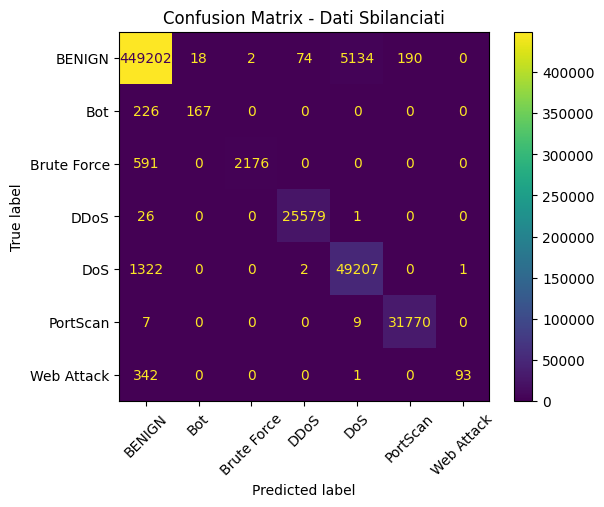

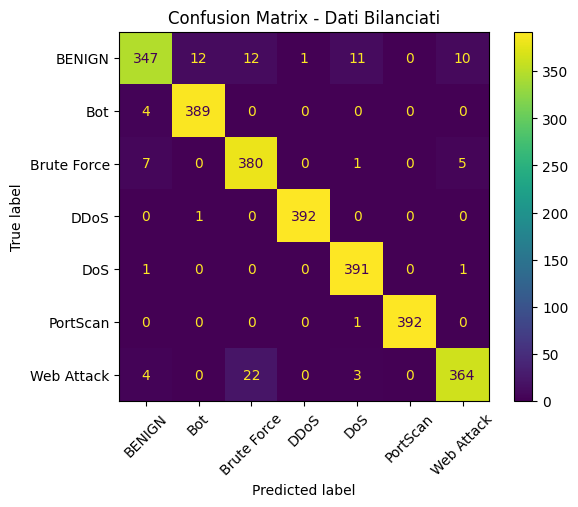

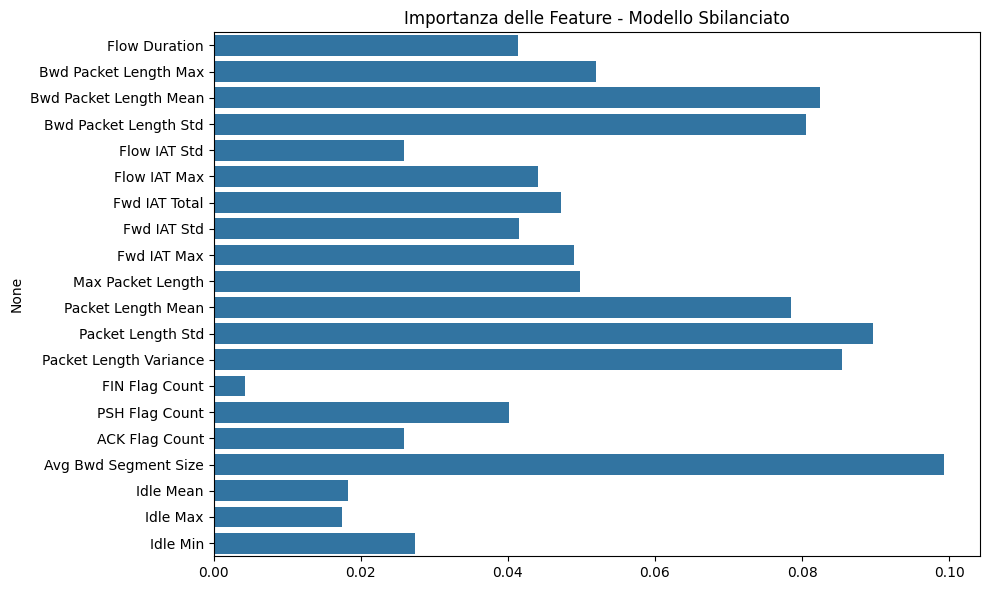

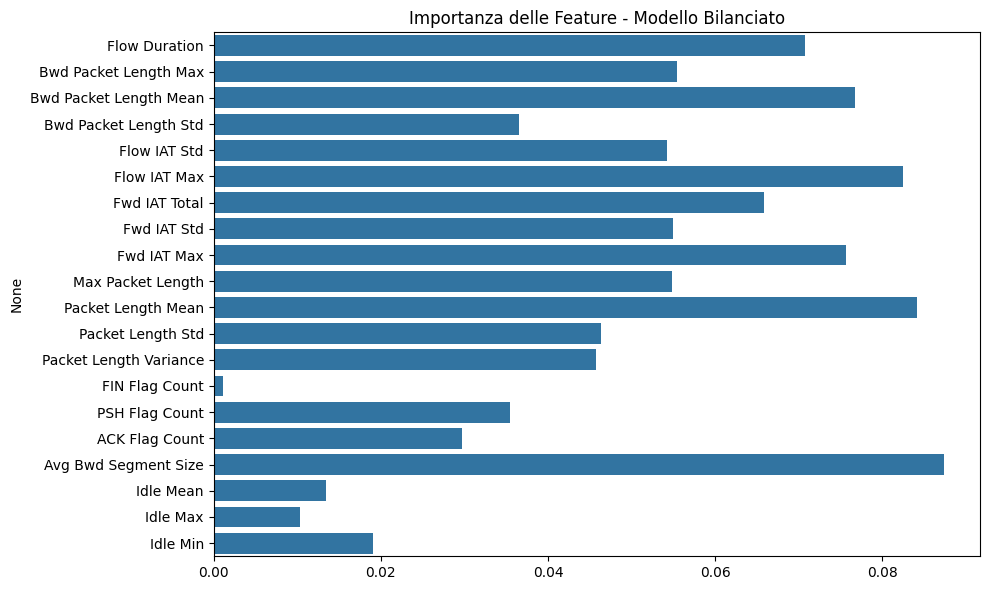

39112

In [6]:
# Rimozione di colonne non imputabili
non_feature_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
# Use X from the previous steps (after label encoding and drop)
X = X.drop(columns=[col for col in non_feature_cols if col in X.columns], errors='ignore')
#Elimino spaziature nomi delle features
X.columns = X.columns.str.strip()

# Codifica di feature categoriche
for col in X.select_dtypes(include=['object']).columns:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))

# Rimpiazzo inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputazione valori assenti
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Feature selection
selector = SelectKBest(score_func=chi2, k=20)

X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)


# Matrice di correlazione tra feature selezionate
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice di Correlazione tra le Feature Selezionate")
plt.tight_layout()
plt.show()



# Split (originali)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Training 1: modello su dati originali
sk_rf_full = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
sk_rf_full.fit(X_train_full, y_train_full)

# Curva di apprendimento del modello sbilanciato
train_sizes, train_scores, test_scores = learning_curve(
    sk_rf_full, X_train_full, y_train_full,
    cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training F1 Score")
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation F1 Score")
plt.title("Curva di Apprendimento - F1 Score (Modello bilanciato)")
plt.xlabel("Dimensione del Training Set")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Training 2: modello su dati bilanciati
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train_full, y_train_full)
X_test_bal, y_test_bal = rus.fit_resample(X_test_full, y_test_full)

sk_rf_bal = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
sk_rf_bal.fit(X_train_bal, y_train_bal)


# Curva di apprendimento del modello bilanciato
train_sizes, train_scores, test_scores = learning_curve(
    sk_rf_bal, X_train_bal, y_train_bal,
    cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training F1 Score")
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation F1 Score")
plt.title("Curva di Apprendimento - F1 Score (Modello Bilanciato)")
plt.xlabel("Dimensione del Training Set")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Valutazione modelli
def evaluate_model(X_set, y_true, model, name):
    y_pred = model.predict(X_set)
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred))

evaluate_model(X_test_full, y_test_full, sk_rf_full, "Test Set (Sbilanciato)")
evaluate_model(X_test_bal, y_test_bal, sk_rf_bal, "Test Set (Bilanciato)")

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(sk_rf_full, X_test_full, y_test_full, display_labels=le.classes_, xticks_rotation=45)
plt.title("Confusion Matrix - Dati Sbilanciati")
plt.show()

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(sk_rf_bal, X_test_bal, y_test_bal, display_labels=le.classes_, xticks_rotation=45)
plt.title("Confusion Matrix - Dati Bilanciati")
plt.show()


# Importanza delle feature per modello su dati sbilanciati
importances_full = sk_rf_full.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_full, y=selected_features)
plt.title("Importanza delle Feature - Modello Sbilanciato")
plt.tight_layout()
plt.show()

# Importanza delle feature per modello su dati bilanciati
importances_bal = sk_rf_bal.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_bal, y=selected_features)
plt.title("Importanza delle Feature - Modello Bilanciato")
plt.tight_layout()
plt.show()


# Libera la memoria
del X, y
gc.collect()

Classi viste dal label encoder: ['BENIGN' 'Bot' 'Brute Force' 'DDoS' 'DoS' 'PortScan' 'Web Attack']
Numero classi: 7


 98%|===================| 685/700 [00:24<00:00]       

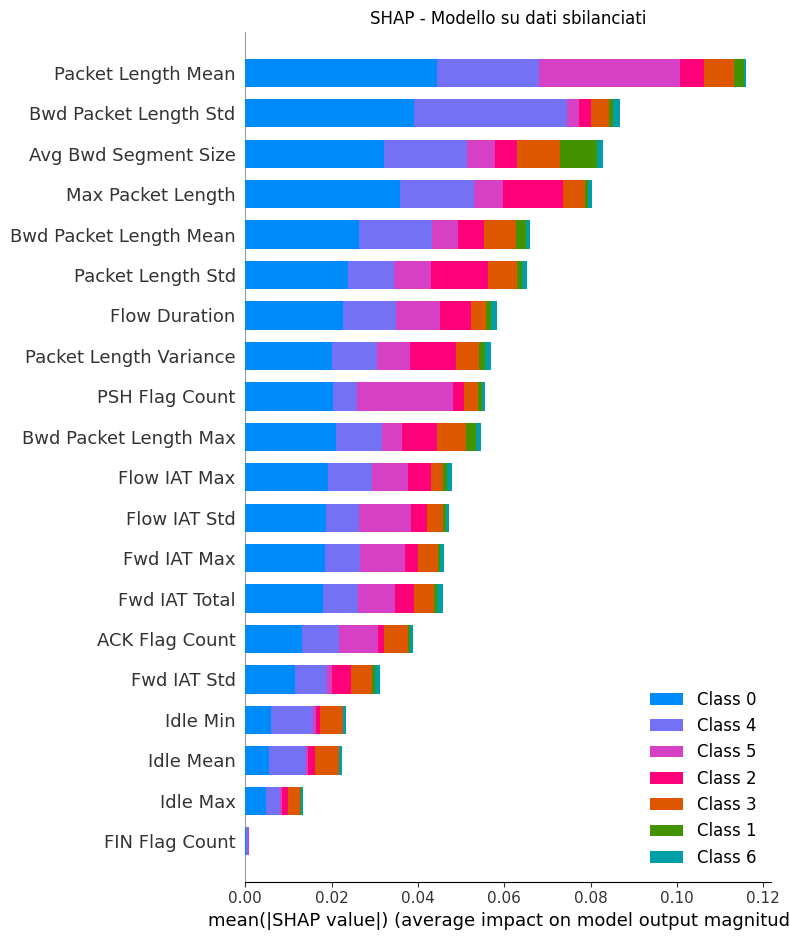

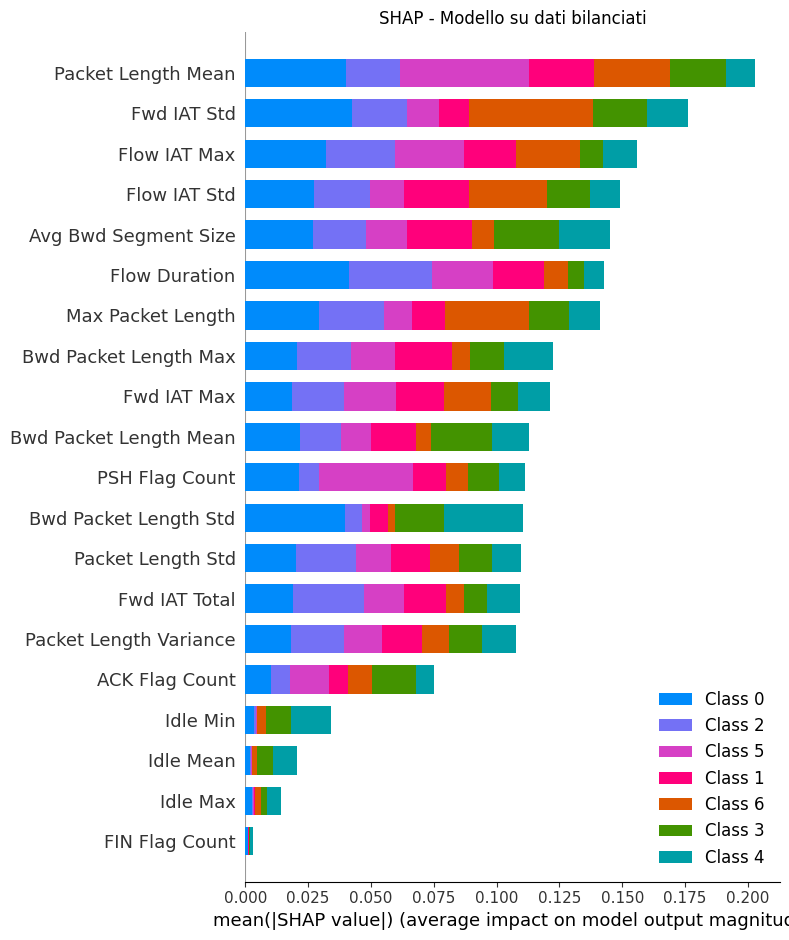

In [ ]:
print("Classi viste dal label encoder:", le.classes_)
print("Numero classi:", len(le.classes_))

# Spiegabilità SHAP
def shap_summary(model, data, title="SHAP Summary"):
    background = data.sample(n=100, random_state=42) if len(data) > 100 else data
    explainer = shap.Explainer(model, background)
    shap_values = explainer(background, check_additivity=False)

    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values, background, feature_names=background.columns, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

shap_summary(sk_rf_full, X_test_full, "SHAP - Modello su dati sbilanciati")
shap_summary(sk_rf_bal, X_test_bal, "SHAP - Modello su dati bilanciati")



In [ ]:
# Salvataggio del modello sklearn e del codificatore con joblib
try:
    with open('rf_model_imbalanced.joblib', 'wb') as f:
        joblib.dump(sk_rf_full, f)
    with open('rf_model_balanced.joblib', 'wb') as f:
        joblib.dump(sk_rf_bal, f)
    with open('label_encoder.joblib', 'wb') as f:
        joblib.dump(le, f)
    with open('scaler.joblib', 'wb') as f:
        joblib.dump(scaler, f)
    with open('imputer.joblib', 'wb') as f:
        joblib.dump(imputer, f)
    with open('selected_features.joblib', 'wb') as f:
        joblib.dump(selected_features.tolist(), f)
    print("Modello, codificatore e oggetti di preprocessing salvati con joblib.")
except Exception as e:
    print("Errore nel salvataggio dei file:", e)


Modello, codificatore e oggetti di preprocessing salvati con joblib.
